## Purpose

To begin answering our business requirement, which, as a reminder, is providing insights related to which customers are more likely to buy a game about to be released, we start by finding out the gold standard for customer segmentation. In our case, the game in question is NieR:Automata$^{TM}$, and the methodology in question is cohort analysis.

This Notebook explores the different cohort analysis types on our customer dataset. This is a simple training notebook, as 2 of the 3 cohort types are not very useful for the task at hand.

The three types are:

 - Time cohorts: classifies groups of customers based on when they signed up for a service, or purchased a product. This analysis stream useful for understandong retention of customer in time, but requires us to have data that shows user engagement with a service/app over time, and the data we have doesn't really fill that requirement. This notebook does not cover this.
 - Behaviour cohorts: classifies groups of customers based on the type of products or services they bought or signed up for. This stream is very useful for clustering customers based on shopping habits.
 - Size cohorts: classifies users based on how long or how much they spent. This could be useful in a different exercise: identifying whales (https://www.blog.udonis.co/mobile-marketing/mobile-games/mobile-games-whales#:~:text=Whales%20are%20the%20users%20that,that%20easy%20to%20%E2%80%9Ccatch%E2%80%9D). However, this notebook will not go into more detail than this.

In [4]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np  # For data processing
import pandas as pd  # For processing and IO

import datetime as dt  # For processing date objects

import seaborn as sns  # For plotting
from matplotlib import pyplot as plt
%matplotlib inline

### Data loading and preprocessing

Let's load the relevant data, which comes from the `purchase_data.csv` file in `data/raw/`. Here, we are loading the relevant data file in pandas, making sure that the timestamp column is converted to a datetime column, which we can manipulate using the `.dt` accessor.

In [6]:
data = pd.read_csv(
    '../data/raw/purchase_data.csv',
    parse_dates=['timestamp_purchased']
)
display(data.head())
print(data.shape)

,userid,appid,timestamp_purchased
0,1cf3a632c88a4344af6e9f8506210967f0d8f1548e69c9...,23300,2016-01-29 04:13:41.554344+00:00
1,2e762ce0a7c28b4474de43aeeeaa6dd68d1c2802a82541...,23300,2016-04-15 18:39:19.554344+00:00
2,ebf7bc41fe51d8fea9f27283d2d4910ae52505262c899e...,23300,2015-09-12 05:44:58.554344+00:00
3,78fcb0ddaac554205138891e3cc8e0a8cc06710639499c...,23300,2015-12-30 17:58:04.554344+00:00
4,5618b22d5737dad09264d0dd42d7c45d26360707be001c...,23300,2013-07-22 23:55:09.554344+00:00


(180995, 3)


Let's have a look at the columns, to have an idea their make up.

There are only 3 columns:

 - userid: a string containing a hashed version of the user information. This is essentially a categorical column.
 - appid: an integer that tells which application the row refers to. This is essentially a categorical column.
 - timestamp_purchased: a datetime column with purchase timestamps. We have converted this into datetime objects during loading.

We can check the min and max of the `timestamp_purchased`, which gives us the earliest and latest purchase dates.

In [7]:
data['timestamp_purchased'].min(), data['timestamp_purchased'].max()

(Timestamp('2013-01-01 07:11:21.554344+0000', tz='UTC'),
 Timestamp('2017-03-01 06:54:44.554344+0000', tz='UTC'))

The data spans approximately 4 years. With this data, we can create 2 extra columns for each user: their frequency and recency metrics. Both of these metrics belong to the set of RFM metrics used commonly in behaviour analysis:
 - Recency: how recently has the user purchased an app from our company?
 - Frequency: How often does the user purchase from our company?
 - Monetary Value: How much do users typically spend per purchase? We don't have access to this data, so we will not use this metric.
 
### A look at recency

Let's start with recency. We can use the data we have been working with to calculate _recency_ by grouping the data by `userid` and finding the highest date stamp (which would be the user's most recent purchase). The _frequency_ can be calculated by grouping the data by `userid` an calculating the total number of purchases by user.

We will define recency as the time from the user's last purchase to the time specified in the exercise description (2017-02-28). We can get the user's latest purchase by grouping the data. We will work on the full dataset for now, and calculate the recency in days.

In [8]:
recency_data = data.groupby(
    'userid',  # group by user
    as_index=False
)[
    'timestamp_purchased'  # focusing on the purchase timestamp
].max()  # and getting the latest purchase
display(recency_data.head())

,userid,timestamp_purchased
0,00002eaf0b53c394391f96a5cae5023ef8ae704797880b...,2016-09-05 04:20:52.554344+00:00
1,00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe2...,2013-03-05 15:10:25.554344+00:00
2,0001bcf0af52b1f0c63fda0eab4844996685f5533bf22b...,2015-10-22 08:28:07.554344+00:00
3,000364b1cefaf76b3abf76080595936a32de847e908ee7...,2016-08-27 03:16:14.554344+00:00
4,00044ddcf913d409bb09aeb32c152eca30a8c9f4cd61da...,2014-04-29 07:55:34.554344+00:00


We want to find the time from last purchase to "today", and we want to do so by rounding the datetime object to the nearest day (after all, does it matter whether the user has not made a purchase for 24 days and 22hrs)?

The function `round_time` is used to get the timedelta and to round it to the nearest day.

In [10]:
def round_time(
    dt1: dt.datetime, 
    dt2: dt.datetime, 
    round_to: str = '1d'
) -> dt.timedelta:
    """
    Returns a rounded timedelta from two datetime objects.
    dt1 and dt2 should be two datetime objects.
    """
    
    return (dt1 - dt2).round(round_to)

In [11]:
# We set a "today" object. This is an arbitrary date.
today = dt.datetime(2017, 2, 28, 0, 0, 0, tzinfo=dt.timezone.utc)

# And calculate the recency
recency_data['user_recency'] = recency_data['timestamp_purchased'].apply(
    lambda x: round_time(today, x).days
)

# We replace recency of -1 with 0 (since recency of -1 is impossible)
recency_data['user_recency'] = recency_data['user_recency'].replace(-1, 0)
display(recency_data.head())

,userid,timestamp_purchased,user_recency
0,00002eaf0b53c394391f96a5cae5023ef8ae704797880b...,2016-09-05 04:20:52.554344+00:00,176
1,00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe2...,2013-03-05 15:10:25.554344+00:00,1455
2,0001bcf0af52b1f0c63fda0eab4844996685f5533bf22b...,2015-10-22 08:28:07.554344+00:00,495
3,000364b1cefaf76b3abf76080595936a32de847e908ee7...,2016-08-27 03:16:14.554344+00:00,185
4,00044ddcf913d409bb09aeb32c152eca30a8c9f4cd61da...,2014-04-29 07:55:34.554344+00:00,1036


Let's explore. First, we will look at the extent of recency values.

In [12]:
print(
    recency_data['user_recency'].min(), 
    recency_data['user_recency'].max()
)

0 1519


In [13]:
recency_data.query('user_recency == 1519')

,userid,timestamp_purchased,user_recency
126465,d2ead3b4d0c28347dcb03ac8ea027a7affc4d04f204ad1...,2013-01-01 07:11:21.554344+00:00,1519


We see that users have last purchased games as recently as "today" (i.e. 2017-02-28), and as far back as the 1$^{st}$ of January, 2013. 

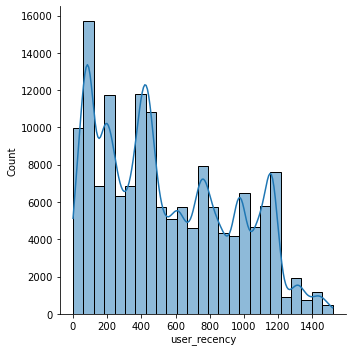

In [14]:
sns.displot(data = recency_data, x = 'user_recency', kde=True, bins = 25)

<AxesSubplot:xlabel='user_recency'>

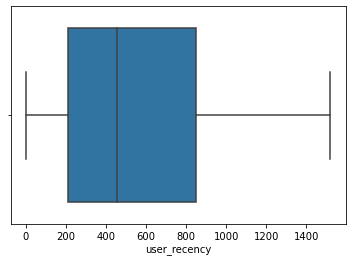

In [15]:
sns.boxplot(data = recency_data, x = 'user_recency')

From the plots above, the recency data appears to be right skewed, with a low right tail, and there do not appear to be any outliers based on quantiles.

### A look at frequency

Let's calculate the frequency values! The frequency is defined as the number of purchases in a given period. Since our data spans almost exactly 4 years, we can sum the number of purchases per user and divide the result by 4.

In [18]:
frequency_data = data.groupby(
    'userid', 
)['userid'].count().div(4).rename('user_frequency').reset_index()
display(frequency_data)

,userid,user_frequency
0,00002eaf0b53c394391f96a5cae5023ef8ae704797880b...,0.25
1,00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe2...,0.25
2,0001bcf0af52b1f0c63fda0eab4844996685f5533bf22b...,0.25
3,000364b1cefaf76b3abf76080595936a32de847e908ee7...,0.25
4,00044ddcf913d409bb09aeb32c152eca30a8c9f4cd61da...,0.25
...,...,...
153201,fffe5f488a6795e0cf201a22f3e14fd9e5edc238b8e7cc...,0.25
153202,fffe61ee06a14eb298711bb3a15e627f89a03048c93a64...,0.25
153203,ffff0366ce6fca05e189be83e199c5efd05d1a72f628ba...,0.25
153204,ffff81c2a0938752d35139f9990671df0b26c4d70b4c78...,0.25


Let's explore. First, we will look at the extent of frequency values.

In [17]:
print(
    'Min frequency: ', frequency_data['user_frequency'].min(),
    '\nMax frequency: ', frequency_data['user_frequency'].max(),
    '\nAvg frequency: ', frequency_data['user_frequency'].mean()
)

Min frequency:  0.25 
Max frequency:  8.75 
Avg frequency:  0.29534580891087814


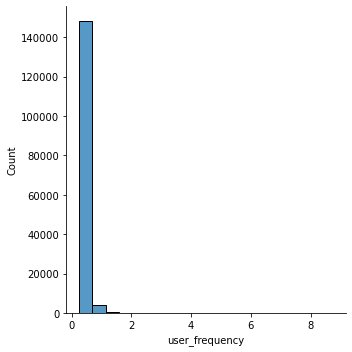

In [19]:
sns.displot(data = frequency_data, x = 'user_frequency')

<AxesSubplot:xlabel='user_frequency'>

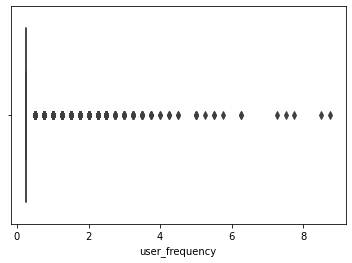

In [20]:
sns.boxplot(data = frequency_data, x = 'user_frequency')

The frequency data tells a very different story. It suggests that, while the data is heavily right skewed, the majority of users buy one game every 4 years. The box plot suggests that we should classify any other value as an outlier based on the IQR.

(-0.5, 10.0)

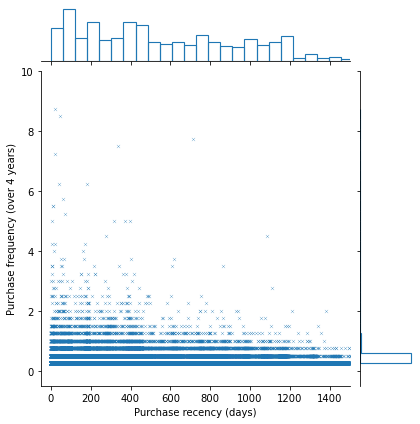

In [22]:
g = sns.jointplot(
    data = pd.merge(
        recency_data,
        frequency_data,
        on='userid',
        how='outer'
    ),
    x = 'user_recency',
    y = 'user_frequency',
    marker = 'x', s = 10,
    marginal_kws=dict(bins=25, fill=False),
)

g.set_axis_labels(
    'Purchase recency (days)', 
    'Purchase frequency (over 4 years)')
g.ax_marg_x.set_xlim(-50, 1500)
g.ax_marg_y.set_ylim(-0.5, 10)

As we can see, the number of purchases is as low as 1/4, which is one purchase for the 4 years, and as high as 8.75, which represents 35 purchases in the 4 years. The average of 0.30, which is slightly higher than the minimum, indicates that users tend to buy, on average, 1 game from our company every 4 years.

Plotting the two quantities reveals that the majority of users purchases 1 to 2 games sporadically. 

We can add 2 more pieces of data. The first one, which we will tackle in the next Notebook, will help us develop an appreciation for how the genre of the game changes our analysis based on RF values. The other piece of data is related to churn.

---

An important question we need to ask is: have these customers churned? A bigger question is: what recency/frequency values do we consider users to have churned? This is a fairly difficult question to answer, as it very much depends on the context. It is probably ok to remove users based on their high recency, but we should experiment with including all users and then progressively removing them based on their recency.

An potential fix to the frequency is to select a fixed time range (e.g. 6 months or 1 year) and create frequency values for each customer for each of those years.

Since we have data for 4 years, we will find the frequency for each user, for each of the 4 years. We will combine the last two years, since we only have 2 months for 2017.

In [23]:
# We get the years and store them to use later
years = np.unique(data['timestamp_purchased'].dt.year)[:-1]

# We will store the results in a dataframe and append to a list
yearly_frequencies = []

for i in range(len(years)):
    
    # We create a boolean mask for each year
    if i >= len(years) - 1:
        mask = data['timestamp_purchased'].dt.year >= years[i]
    else:
        mask = data['timestamp_purchased'].dt.year == years[i]
    
    # And subset the data
    data_subset = data[mask]
    
    # Then we aggregate
    yearly_frequencies.append(data_subset.groupby('userid').aggregate(
        {'userid': 'count'}
    ).rename(columns={
        'userid': f'user_frequency_{years[i]}',
        }
    ))

Then, we want to merge all of the dataframes into one. We can use `reduce` to help us with this process:

In [24]:
from functools import reduce

frequencies_data = reduce(
    lambda left,right: pd.merge(
        left, right, 
        left_index=True,  # merge using the left dataframe's index
        right_index=True,  # merge using the right dataframe's index
        how='outer'  # keep all of the data
    ),
    yearly_frequencies
).fillna(0).astype(int) # fill null frequencies with 0 to signify user did not purchase
display(frequencies_data.head())

,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016
userid,,,,
00002eaf0b53c394391f96a5cae5023ef8ae704797880bb97b1a78eb0c6eb05a,0,0,0,1
00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe280dd1adb8b143e3ff1,1,0,0,0
0001bcf0af52b1f0c63fda0eab4844996685f5533bf22b9635858cf2b97ba162,0,0,1,0
000364b1cefaf76b3abf76080595936a32de847e908ee70cf0ac25cff96b6fe0,0,0,0,1
00044ddcf913d409bb09aeb32c152eca30a8c9f4cd61da8906537d9df5e86178,0,1,0,0


The data now lefts us see that, for example, user with id **00002eaf0b53c394391f96a5cae5023ef8ae704797880bb97b1a78eb0c6eb05a** purchased one game in 2016-2017, but user with id **0001bcf0af52b1f0c63fda0eab4844996685f5533bf22b9635858cf2b97ba162** bought a game in 2015-2016, but has not purchased anything else.

Defining churn depends on the business case. If we are considering a game that users are meant to engage with every day, we would probably be justified in considering churned a user who has not engaged for at least 2 weeks. If we are considering a customer of a large chain supermarket, we might also take 2 weeks to 1 month as a cut-off for churn, considering that, "on average, households now shop 4.9 times a week, across 2.7 different brands" (from https://www.goinspire.co.uk/blog/customer-churn-rate-by-sector/). If we are analysing customer data for a monthly subscription company, we may (for example) consider churned a customer who cancelled their subcription and has not reactivated it in 3 months.

In our case, we may considered a user that has not purchased a game in 3 years as churned. Defining churn is beyond the scope of this exercise, since we are not aiming to determine what causes churn.

In [25]:
frequencies_data['sum_purchases'] = frequencies_data.sum(axis=1)
display(frequencies_data.sort_values('sum_purchases'))

,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016,sum_purchases
userid,,,,,
00002eaf0b53c394391f96a5cae5023ef8ae704797880bb97b1a78eb0c6eb05a,0,0,0,1,1
a50495404561ce885695d4269da4f0874e5d4d29c8bd3a091c704b4f81fb6edf,0,0,0,1,1
a502e5eb61d78269453d2f6aef9616a841c5c7d02dfda10d1efcb861e5700814,0,0,0,1,1
a502e2c43ead952ba0b3f44de87bf01260e29a4a9af0d0c47f29b11c4583406e,0,0,0,1,1
a501ff908531db342b70a312769fd5fa2e1138500bd1d23ffefcb5cde9bd37a5,0,0,1,0,1
...,...,...,...,...,...
585c7ce403ac8a5a4add4d421b14eb60390ed7d5775075dc7e5263aeccfd102b,6,6,9,8,29
02af4f533c4c4a1efbee21b69b1d8e6d84e255dc5f25c4b76b1938a0d77c8cae,0,0,28,2,30
42c37973743d7c79bf165bc656307e7e63cc07aa0d4fe48747f2d84de1bebd3b,0,5,26,0,31


In [26]:
frequencies_data.mean()

user_frequency_2013    0.108945
user_frequency_2014    0.254031
user_frequency_2015    0.318258
user_frequency_2016    0.500150
sum_purchases          1.181383
dtype: float64

When we split the data this way, we see that there has been an increase in the average number of purchases across the years, a positive indication in the interest for games from our company.

We can use this data to also categorise users based on their purchase history. For example, users who have not purchased anything from the last 2 years could be considered churned or dormant (see, for example, user **00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe280dd1adb8b143e3ff1**); users who have purchased at least one game every year could be labeled regulars or loyals (see, for example, user **b8627340a2d3370533666460756b96d868a0325e518e4f95d0457c084bbb8064**); and users who started recently purchasing SquareEnix games could be considered newcomers or developing users (for example, user **a502e2c43ead952ba0b3f44de87bf01260e29a4a9af0d0c47f29b11c4583406e**). We won't be doing these classifications, since they can be arbitrary and highly dependent of the business context.

Let's merge these new datasets into one and move on to looking at a simple clustering exercise.

In [27]:
recency_data.drop(
    'timestamp_purchased', 
    axis=1
).merge(
    frequencies_data.drop('sum_purchases', axis=1).reset_index(),
    on='userid',
    how='outer'
).to_json(
    '../data/processed/simple_userRF.json'
)